1. ~~Which lesson appears to attract the most traffic consistently across cohorts (per program)?~~
1. ~~Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?~~
1. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
1. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 
1. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 
1. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
1. Which lessons are least accessed? 
1. Anything else I should be aware of? 

* What topics are more difficult than others
* Lessons being accessed the least - maybe the lessons need to be re-written or the lesson is simple. If a lesson that is not being used at all, maybe there are lessons that replace them or they need to be merged
* Maybe there is a particular lesson a particular cohort accessed more than the others. Needed to understand how instructors are doing
* Find outliers to determine if there is webscraping happening on the lessons or not.
  * IPs
  * User agents
  * Odd times 
* Date range for when the shut off was successful
* What content are grads are looking at into their jobs


In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

print("Initalized")

Initalized


In [2]:
# Read the data
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None, na_values='"-"')
# From the https://ds.codeup.com/anomaly-detection/time-series-anomaly-detection-part-3/ rename columns as needed
data.columns=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
# Combine the date time columns and convert it to a datetimeobj
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data.datetime)
# Create a columns for hour, day name, and month
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day_name()
data['month'] = data['datetime'].dt.month_name()
#Set the index to the new datetime column and sort it
data

date      time                          page_viewed  user_id  \
0       2018-01-26  09:55:03                                    /        1   
1       2018-01-26  09:56:02                              java-ii        1   
2       2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
3       2018-01-26  09:56:06   slides/object_oriented_programming        1   
4       2018-01-26  09:56:24            javascript-i/conditionals        2   
...            ...       ...                                  ...      ...   
719454  2020-11-02  16:48:13          javascript-i/coffee-project      763   
719455  2020-11-02  16:48:17              javascript-i/mapbox-api      771   
719456  2020-11-02  16:48:18          javascript-i/coffee-project      771   
719457  2020-11-02  16:48:28         javascript-i/bom-and-dom/bom      771   
719458  2020-11-02  16:48:47         javascript-i/bom-and-dom/bom      763   

        cohort_id               ip            datetime  hour     day     month  
0             8.0     97.105.19.61 2018-01-26 09:55:03     9  Friday   January  
1             8.0     97.105.19.61 2018-01-26 09:56:02     9  Friday   January  
2             8.0     97.105.19.61 2018-01-26 09:56:05     9  Friday   January  
3             8.0     97.105.19.61 2018-01-26 09:56:06     9  Friday   January  
4            22.0     97.105.19.61 2018-01-26 09:56:24     9  Friday   January  
...           ...              ...                 ...   ...     ...       ...  
719454       62.0  107.192.148.199 2020-11-02 16:48:13    16  Monday  November  
719455       62.0  172.125.226.175 2020-11-02 16:48:17    16  Monday  November  
719456       62.0  172.125.226.175 2020-11-02 16:48:18    16  Monday  November  
719457       62.0  172.125.226.175 2020-11-02 16:48:28    16  Monday  November  
719458       62.0  107.192.148.199 2020-11-02 16:48:47    16  Monday  November  

[719459 rows x 10 columns]

In [3]:
# Read the cohort data Zach gave us into a Df
cohort = pd.read_csv('cohorts.csv')
# Merge the cohort data onto usage df 
data = data.merge(cohort, on='cohort_id', how='left')
#print the head
data.shape

(719459, 14)

In [4]:
# Create an empty column to hold classtype 
data['classtype'] = 'x'
# Use .loc and column name to create classtype values from class id
data.loc[data['program_id'] == 1, 'classtype'] = 'Web-SanAntonio'
data.loc[data['program_id'] == 2, 'classtype'] = 'Web-Dallas'
data.loc[data['program_id'] == 3, 'classtype'] = 'DataScience-SanAntonio'
data.loc[data['program_id'] == 4, 'classtype'] = 'Web-Houston'
#Then split the class type column into two on -
data[['program','location']] = data.classtype.str.split("-",expand=True) 
# Base data frame created 
data

date      time                          page_viewed  user_id  \
0       2018-01-26  09:55:03                                    /        1   
1       2018-01-26  09:56:02                              java-ii        1   
2       2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
3       2018-01-26  09:56:06   slides/object_oriented_programming        1   
4       2018-01-26  09:56:24            javascript-i/conditionals        2   
...            ...       ...                                  ...      ...   
719454  2020-11-02  16:48:13          javascript-i/coffee-project      763   
719455  2020-11-02  16:48:17              javascript-i/mapbox-api      771   
719456  2020-11-02  16:48:18          javascript-i/coffee-project      771   
719457  2020-11-02  16:48:28         javascript-i/bom-and-dom/bom      771   
719458  2020-11-02  16:48:47         javascript-i/bom-and-dom/bom      763   

        cohort_id               ip            datetime  hour     day  \
0             8.0     97.105.19.61 2018-01-26 09:55:03     9  Friday   
1             8.0     97.105.19.61 2018-01-26 09:56:02     9  Friday   
2             8.0     97.105.19.61 2018-01-26 09:56:05     9  Friday   
3             8.0     97.105.19.61 2018-01-26 09:56:06     9  Friday   
4            22.0     97.105.19.61 2018-01-26 09:56:24     9  Friday   
...           ...              ...                 ...   ...     ...   
719454       62.0  107.192.148.199 2020-11-02 16:48:13    16  Monday   
719455       62.0  172.125.226.175 2020-11-02 16:48:17    16  Monday   
719456       62.0  172.125.226.175 2020-11-02 16:48:18    16  Monday   
719457       62.0  172.125.226.175 2020-11-02 16:48:28    16  Monday   
719458       62.0  107.192.148.199 2020-11-02 16:48:47    16  Monday   

           month     name  start_date    end_date  program_id       classtype  \
0        January  Hampton  2015-09-22  2016-02-06         1.0  Web-SanAntonio   
1        January  Hampton  2015-09-22  2016-02-06         1.0  Web-SanAntonio   
2        January  Hampton  2015-09-22  2016-02-06         1.0  Web-SanAntonio   
3        January  Hampton  2015-09-22  2016-02-06         1.0  Web-SanAntonio   
4        January    Teddy  2018-01-08  2018-05-17         2.0      Web-Dallas   
...          ...      ...         ...         ...         ...             ...   
719454  November  Jupiter  2020-09-21  2021-03-30         2.0      Web-Dallas   
719455  November  Jupiter  2020-09-21  2021-03-30         2.0      Web-Dallas   
719456  November  Jupiter  2020-09-21  2021-03-30         2.0      Web-Dallas   
719457  November  Jupiter  2020-09-21  2021-03-30         2.0      Web-Dallas   
719458  November  Jupiter  2020-09-21  2021-03-30         2.0      Web-Dallas   

       program    location  
0          Web  SanAntonio  
1          Web  SanAntonio  
2          Web  SanAntonio  
3          Web  SanAntonio  
4          Web      Dallas  
...        ...         ...  
719454     Web      Dallas  
719455     Web      Dallas  
719456     Web      Dallas  
719457     Web      Dallas  
719458     Web      Dallas  

[719459 rows x 17 columns]

In [5]:
data.isnull().sum()

date               0
time               0
page_viewed        1
user_id            0
cohort_id      44840
ip                 0
datetime           0
hour               0
day                0
month              0
name           44840
start_date     44840
end_date       44840
program_id     44840
classtype          0
program            0
location       44840
dtype: int64

In [6]:
# Create seperate data fames for web and datascience
web = data[data['program']=='Web']
ds = data[data['program']=='DataScience']
# sort the values by datetime
ds = ds.sort_values(by='datetime')
web = web.sort_values(by='datetime')
# set the index to datetime
ds=ds.set_index('datetime')
web=web.set_index('datetime')
ds

date      time               page_viewed  user_id  \
datetime                                                                       
2019-08-20 09:39:58  2019-08-20  09:39:58                         /      466   
2019-08-20 09:39:59  2019-08-20  09:39:59                         /      467   
2019-08-20 09:39:59  2019-08-20  09:39:59                         /      468   
2019-08-20 09:40:02  2019-08-20  09:40:02                         /      469   
2019-08-20 09:40:08  2019-08-20  09:40:08                         /      470   
...                         ...       ...                       ...      ...   
2020-11-02 15:50:07  2020-11-02  15:50:07        appendix/open_data      698   
2020-11-02 15:52:23  2020-11-02  15:52:23        timeseries/sarimax      698   
2020-11-02 15:57:22  2020-11-02  15:57:22                         /      616   
2020-11-02 15:57:25  2020-11-02  15:57:25  search/search_index.json      616   
2020-11-02 15:57:29  2020-11-02  15:57:29          fundamentals/git      616   

                     cohort_id             ip  hour      day     month  \
datetime                                                                 
2019-08-20 09:39:58       34.0   97.105.19.58     9  Tuesday    August   
2019-08-20 09:39:59       34.0   97.105.19.58     9  Tuesday    August   
2019-08-20 09:39:59       34.0   97.105.19.58     9  Tuesday    August   
2019-08-20 09:40:02       34.0   97.105.19.58     9  Tuesday    August   
2019-08-20 09:40:08       34.0   97.105.19.58     9  Tuesday    August   
...                        ...            ...   ...      ...       ...   
2020-11-02 15:50:07       59.0  24.28.150.196    15   Monday  November   
2020-11-02 15:52:23       59.0  24.28.150.196    15   Monday  November   
2020-11-02 15:57:22       55.0   70.114.9.241    15   Monday  November   
2020-11-02 15:57:25       55.0   70.114.9.241    15   Monday  November   
2020-11-02 15:57:29       55.0   70.114.9.241    15   Monday  November   

                       name  start_date    end_date  program_id  \
datetime                                                          
2019-08-20 09:39:58   Bayes  2019-08-19  2020-01-30         3.0   
2019-08-20 09:39:59   Bayes  2019-08-19  2020-01-30         3.0   
2019-08-20 09:39:59   Bayes  2019-08-19  2020-01-30         3.0   
2019-08-20 09:40:02   Bayes  2019-08-19  2020-01-30         3.0   
2019-08-20 09:40:08   Bayes  2019-08-19  2020-01-30         3.0   
...                     ...         ...         ...         ...   
2020-11-02 15:50:07  Darden  2020-07-13  2021-01-12         3.0   
2020-11-02 15:52:23  Darden  2020-07-13  2021-01-12         3.0   
2020-11-02 15:57:22   Curie  2020-02-03  2020-07-07         3.0   
2020-11-02 15:57:25   Curie  2020-02-03  2020-07-07         3.0   
2020-11-02 15:57:29   Curie  2020-02-03  2020-07-07         3.0   

                                  classtype      program    location  
datetime                                                              
2019-08-20 09:39:58  DataScience-SanAntonio  DataScience  SanAntonio  
2019-08-20 09:39:59  DataScience-SanAntonio  DataScience  SanAntonio  
2019-08-20 09:39:59  DataScience-SanAntonio  DataScience  SanAntonio  
2019-08-20 09:40:02  DataScience-SanAntonio  DataScience  SanAntonio  
2019-08-20 09:40:08  DataScience-SanAntonio  DataScience  SanAntonio  
...                                     ...          ...         ...  
2020-11-02 15:50:07  DataScience-SanAntonio  DataScience  SanAntonio  
2020-11-02 15:52:23  DataScience-SanAntonio  DataScience  SanAntonio  
2020-11-02 15:57:22  DataScience-SanAntonio  DataScience  SanAntonio  
2020-11-02 15:57:25  DataScience-SanAntonio  DataScience  SanAntonio  
2020-11-02 15:57:29  DataScience-SanAntonio  DataScience  SanAntonio  

[68017 rows x 16 columns]

In [7]:
# resample the index by moth
ds_month = ds.groupby(['name', 'page_viewed']).resample('M').size().reset_index().set_index('datetime')
web_month = web.groupby(['name', 'page_viewed']).resample('M').size().reset_index().set_index('datetime')
ds_month.columns=['name', 'page', 'hits']
web_month.columns=['name', 'page', 'hits']
web_month

name                       page  hits
datetime                                              
2019-03-31  Andromeda                          /   132
2019-04-30  Andromeda                          /   232
2019-05-31  Andromeda                          /   188
2019-06-30  Andromeda                          /   110
2019-07-31  Andromeda                          /   108
...               ...                        ...   ...
2019-07-31       Zion  uploads/598dc43df39e2.jpg     1
2019-12-31       Zion           web-design/intro     1
2019-07-31       Zion      web-design/ui/visuals     1
2019-07-31       Zion       web-design/ux/layout     1
2019-07-31       Zion      web-design/ux/purpose     1

[80029 rows x 3 columns]

# Consistently Referencing Material Significantly
* Data Sceince

In [8]:
# group by cohort name and page to and mean to get the total number of hits per page per cohort
ds_avghits = ds_month.groupby(['name', 'page']).sum().unstack().reset_index(col_level=1)
ds_avghits.columns = ds_avghits.columns.droplevel(0)
ds_avghits = ds_avghits.reset_index()
ds_avghits = ds_avghits.transpose()
ds_avghits = ds_avghits.drop(labels=['index', 'name'])
ds_avghits = ds_avghits.reset_index().set_index('page', drop=True)
ds_columns=ds_month.name.unique()
ds_avghits.columns=ds_columns
ds_avghits = ds_avghits.fillna(0)
ds_avghits['total_hits'] = ds_avghits.sum(axis=1)
ds_avghits['total_avg'] = ds_avghits.mean(axis=1)
ds_avghits[ds_avghits['total_avg'] >= 300]

Bayes   Curie  Darden  \
page                                                                        
/                                                  1842.0  1523.0  2041.0   
1-fundamentals/1.1-intro-to-data-science            615.0   461.0   460.0   
1-fundamentals/1.2-data-science-pipeline            221.0   146.0   271.0   
1-fundamentals/AI-ML-DL-timeline.jpg                624.0   465.0   470.0   
1-fundamentals/DataToAction_v2.jpg                  230.0   148.0   284.0   
1-fundamentals/modern-data-scientist.jpg            626.0   467.0   470.0   
10-anomaly-detection/1-overview                     383.0   345.0    14.0   
10-anomaly-detection/AnomalyDetectionCartoon.jpeg   386.0   345.0    14.0   
3-sql/1-mysql-overview                              142.0   441.0   121.0   
6-regression/1-overview                             521.0   595.0     7.0   
classification/overview                              10.0    91.0   759.0   
classification/scale_features_or_not.svg              6.0    46.0   590.0   
search/search_index.json                            551.0   480.0   300.0   
sql/mysql-overview                                    3.0    99.0   513.0   

                                                   total_hits  total_avg  
page                                                                      
/                                                      5406.0     2703.0  
1-fundamentals/1.1-intro-to-data-science               1536.0      768.0  
1-fundamentals/1.2-data-science-pipeline                638.0      319.0  
1-fundamentals/AI-ML-DL-timeline.jpg                   1559.0      779.5  
1-fundamentals/DataToAction_v2.jpg                      662.0      331.0  
1-fundamentals/modern-data-scientist.jpg               1563.0      781.5  
10-anomaly-detection/1-overview                         742.0      371.0  
10-anomaly-detection/AnomalyDetectionCartoon.jpeg       745.0      372.5  
3-sql/1-mysql-overview                                  704.0      352.0  
6-regression/1-overview                                1123.0      561.5  
classification/overview                                 860.0      430.0  
classification/scale_features_or_not.svg                642.0      321.0  
search/search_index.json                               1331.0      665.5  
sql/mysql-overview                                      615.0      307.5

* Webdev

In [9]:
# group by cohort name and page to and mean to get the total number of hits per page per cohort
web_avghits = web_month.groupby(['name', 'page']).sum().unstack().reset_index(col_level=1)
web_avghits.columns = web_avghits.columns.droplevel(0)
web_avghits = web_avghits.reset_index()
web_avghits = web_avghits.transpose()
web_avghits = web_avghits.drop(labels=['index', 'name'])
web_avghits = web_avghits.reset_index().set_index('page', drop=True)
web_columns=web_month.name.unique()
web_avghits.columns=web_columns
web_avghits = web_avghits.fillna(0)
web_avghits['total_hits'] = web_avghits.sum(axis=1)
web_avghits['total_avg'] = web_avghits.mean(axis=1)
web_avghits[web_avghits['total_avg'] >= 300]

Andromeda    Apex  Apollo  Arches  Badlands   Bash  \
page                                                                           
/                            1156.0  1244.0     1.0   622.0      17.0  532.0   
appendix                      161.0   426.0     0.0   133.0       0.0   80.0   
html-css                      372.0   708.0     0.0   215.0       2.0  214.0   
java-i                        336.0   528.0     0.0   132.0       1.0  157.0   
java-ii                       395.0   595.0     0.0   167.0       0.0  190.0   
java-iii                      430.0   616.0     0.0   153.0       0.0   72.0   
javascript-i                  509.0   610.0     0.0   294.0       1.0  319.0   
javascript-ii                 290.0   431.0     0.0   204.0       0.0  175.0   
jquery                        335.0   437.0     0.0   133.0       0.0  233.0   
mysql                         346.0   445.0     0.0    95.0       0.0  136.0   
mysql/tables                  316.0   332.0     0.0    36.0       0.0  101.0   
search/search_index.json      318.0  1361.0     0.0    45.0       0.0  363.0   
spring                        485.0   572.0     0.0   192.0       0.0   29.0   
toc                           637.0   799.0     0.0    66.0       2.0  317.0   

                          Betelgeuse   Ceres  Deimos  Denali  ...   Staff  \
page                                                          ...           
/                              868.0  1620.0  1319.0     1.0  ...  4633.0   
appendix                       180.0   408.0   287.0     0.0  ...   989.0   
html-css                       425.0   753.0   609.0     0.0  ...   977.0   
java-i                         422.0   510.0   434.0     0.0  ...   624.0   
java-ii                        444.0   667.0   506.0     0.0  ...   884.0   
java-iii                       444.0   674.0   517.0     0.0  ...   908.0   
javascript-i                   686.0   977.0   696.0     0.0  ...  1263.0   
javascript-ii                  374.0   519.0   392.0     0.0  ...   744.0   
jquery                         540.0   632.0   466.0     0.0  ...   615.0   
mysql                          342.0   617.0   498.0     0.0  ...   594.0   
mysql/tables                   332.0   377.0   371.0     0.0  ...   261.0   
search/search_index.json       718.0  1376.0   662.0     0.0  ...  1096.0   
spring                         280.0   546.0   512.0     0.0  ...   914.0   
toc                            577.0   909.0   569.0     0.0  ...   612.0   

                           Teddy  Ulysses  Voyageurs  Wrangell  Xanadu  \
page                                                                     
/                         1754.0   1618.0     2098.0    1112.0   916.0   
appendix                   488.0    174.0      393.0     209.0   320.0   
html-css                   225.0    555.0      528.0     405.0   587.0   
java-i                     501.0    375.0      639.0     401.0   483.0   
java-ii                    494.0    423.0      754.0     323.0   501.0   
java-iii                   712.0    411.0      770.0     335.0   495.0   
javascript-i               589.0    523.0      884.0     553.0   718.0   
javascript-ii              468.0    308.0      584.0     278.0   493.0   
jquery                     498.0    363.0      583.0     374.0   543.0   
mysql                      631.0    361.0      663.0     306.0   507.0   
mysql/tables               387.0    308.0      437.0     282.0   373.0   
search/search_index.json    96.0    136.0      328.0     489.0   576.0   
spring                     707.0    396.0      650.0     291.0   453.0   
toc                         81.0     86.0      272.0     990.0   435.0   

                          Yosemite    Zion  total_hits    total_avg  
page                                                                 
/                            962.0  1756.0     30668.0  1614.105263  
appendix                     142.0   289.0      6678.0   351.473684  
html-css                     362.0   649.0     

# Least Referenced Material
* WebDev

In [156]:
web_lesson = pd.DataFrame(web.groupby(['page_viewed']).size())
web_lesson.columns=['views']
web_lesson.describe()

views
count   1939.000000
mean     312.842702
std     1343.568915
min        1.000000
25%        2.000000
50%        8.000000
75%       35.000000
max    30668.000000

In [157]:
web_lesson[lesson['views']<8]

views
page_viewed                                  
.git                                        1
.gitignore                                  1
.well-known/assetlinks.json                 2
0_Classification_Algorithms                 2
1-fundamentals/1-intro-to-data-science      4
...                                       ...
web-design/ux                               1
web-design/ux/layout/.json                  1
web-dev-day-two                             2
wp-admin                                    1
wp-login                                    1

[728 rows x 1 columns]

* Data Science

In [158]:
ds_lesson = pd.DataFrame(ds.groupby(['page_viewed']).size())
ds_lesson.columns=['views']
ds_lesson.describe()

views
count   596.000000
mean    114.120805
std     282.876447
min       1.000000
25%       3.000000
50%      20.000000
75%     160.000000
max    5406.000000

In [160]:
ds_lesson[lesson['views']<20]

views
page_viewed                                              
%20https://github.com/RaulCPena                         1
,%20https://github.com/RaulCPena                        1
1-fundamentals                                         10
1-fundamentals/2.3-visualization                        4
1-fundamentals/2.3-visualization.md                     5
...                                                   ...
timeseries                                              2
timeseries/sarimax                                      7
timeseries/svr                                          8
timeseries/working-with-time-series-data-with-p...      8
working-with-time-series-data                          14

[233 rows x 1 columns]


# Cohorts Referencing Material
* WebDev

In [10]:
used = pd.DataFrame.copy(web_avghits)
for col in web_columns:
    used[col] = used[col]/used['total_hits']
used = used.drop(columns=['total_hits', 'total_avg'])
used = used.transpose()
used = used.drop(labels='Staff', axis=0)
used

page        .git  .gitignore  .well-known/assetlinks.json         /  00_  \
Andromeda    0.0         0.0                          0.0  0.037694  0.0   
Apex         0.0         0.0                          0.0  0.040563  0.0   
Apollo       0.0         0.0                          0.0  0.000033  0.0   
Arches       0.0         0.0                          0.0  0.020282  0.0   
Badlands     0.0         0.0                          0.0  0.000554  0.0   
Bash         0.0         0.0                          0.0  0.017347  0.0   
Betelgeuse   0.0         0.0                          0.0  0.028303  0.0   
Ceres        0.0         0.0                          0.0  0.052824  0.0   
Deimos       0.0         0.0                          0.0  0.043009  0.0   
Denali       0.0         0.0                          0.0  0.000033  0.0   
Europa       0.0         0.0                          0.0  0.039879  0.0   
Everglades   0.0         0.0                          0.0  0.000033  0.0   
Fortuna      0.0         0.0                          0.0  0.063975  0.0   
Franklin     0.0         0.0                          0.0  0.000130  0.0   
Ganymede     0.0         0.0                          0.0  0.052759  0.0   
Glacier      0.0         0.0                          0.0  0.001109  0.0   
Hampton      0.0         0.0                          0.0  0.006848  0.0   
Hyperion     0.0         0.0                          1.0  0.040596  0.0   
Ike          0.0         0.0                          0.0  0.000261  0.0   
Joshua       0.0         0.0                          0.0  0.000261  0.0   
Jupiter      0.0         0.0                          0.0  0.019564  0.0   
Kings        0.0         0.0                          0.0  0.006782  0.0   
Lassen       0.0         0.0                          0.0  0.003750  0.0   
Mammoth      0.0         0.0                          0.0  0.001076  0.0   
Niagara      0.0         0.0                          0.0  0.000946  0.0   
Olympic      0.0         0.0                          0.0  0.007956  0.0   
Pinnacles    0.0         0.0                          0.0  0.004206  0.0   
Quincy       0.0         0.0                          0.0  0.004500  0.0   
Sequoia      0.0         0.0                          0.0  0.020543  0.0   
Teddy        0.0         0.0                          0.0  0.057193  0.0   
Ulysses      0.0         0.0                          0.0  0.052759  0.0   
Voyageurs    1.0         1.0                          0.0  0.068410  0.0   
Wrangell     0.0         0.0                          0.0  0.036259  0.0   
Xanadu       0.0         0.0                          0.0  0.029868  0.0   
Yosemite     0.0         0.0                          0.0  0.031368  0.0   
Zion         0.0         0.0                          0.0  0.057258  0.0   

page        00_index  01_intro  02_listing_files  03_file_paths  \
Andromeda   0.000000  0.000000               0.0       0.000000   
Apex        0.000000  0.000000               0.0       0.000000   
Apollo      0.000000  0.000000               0.0       0.000000   
Arches      0.000000  0.000000               0.0       0.000000   
Badlands    0.000000  0.000000               0.0       0.000000   
Bash        0.000000  0.000000               0.0       0.000000   
Betelgeuse  0.000000  0.000000               0.0       0.000000   
Ceres       0.000000  0.000000               0.0       0.000000   
Deimos      0.000000  0.000000               0.0       0.000000   
Denali      0.000000  0.000000               0.0       0.000000   
Europa      0.000000  0.000000               0.0       0.000000   
Everglades  0.000000  0.000000               0.0       0.000000   
Fortuna     0.000000  0.000000               0.0       0.000000   
Franklin    0.000000  0.000000               0.0       0.000000   
Ganymede    0.000000  0.000000               0.0       0.000000   
Glacier     0.000000  0.000000               0.0       0.000000   
Hampton     0.000000  0.000000               0.0

In [11]:
# Test data frame slicing
used[['web-design/ui/typography']][used['web-design/ui/typography'] >= .1]

page        web-design/ui/typography
Betelgeuse                  0.100386
Ceres                       0.127413
Europa                      0.193050

In [20]:
pages = used.columns
pairs = pd.DataFrame(index=used.index)
for page in pages:
    pairs = pairs.merge(right=(pd.DataFrame(used[page][used[page]>=.1])), how='left', left_index=True, right_index=True)
pairs = pd.concat([pairs, web_avghits[['total_hits']].transpose()])
pairs


page        .git  .gitignore  .well-known/assetlinks.json        /  00_  \
Andromeda    NaN         NaN                          NaN      NaN  NaN   
Apex         NaN         NaN                          NaN      NaN  NaN   
Apollo       NaN         NaN                          NaN      NaN  NaN   
Arches       NaN         NaN                          NaN      NaN  NaN   
Badlands     NaN         NaN                          NaN      NaN  NaN   
Bash         NaN         NaN                          NaN      NaN  NaN   
Betelgeuse   NaN         NaN                          NaN      NaN  NaN   
Ceres        NaN         NaN                          NaN      NaN  NaN   
Deimos       NaN         NaN                          NaN      NaN  NaN   
Denali       NaN         NaN                          NaN      NaN  NaN   
Europa       NaN         NaN                          NaN      NaN  NaN   
Everglades   NaN         NaN                          NaN      NaN  NaN   
Fortuna      NaN         NaN                          NaN      NaN  NaN   
Franklin     NaN         NaN                          NaN      NaN  NaN   
Ganymede     NaN         NaN                          NaN      NaN  NaN   
Glacier      NaN         NaN                          NaN      NaN  NaN   
Hampton      NaN         NaN                          NaN      NaN  NaN   
Hyperion     NaN         NaN                          1.0      NaN  NaN   
Ike          NaN         NaN                          NaN      NaN  NaN   
Joshua       NaN         NaN                          NaN      NaN  NaN   
Jupiter      NaN         NaN                          NaN      NaN  NaN   
Kings        NaN         NaN                          NaN      NaN  NaN   
Lassen       NaN         NaN                          NaN      NaN  NaN   
Mammoth      NaN         NaN                          NaN      NaN  NaN   
Niagara      NaN         NaN                          NaN      NaN  NaN   
Olympic      NaN         NaN                          NaN      NaN  NaN   
Pinnacles    NaN         NaN                          NaN      NaN  NaN   
Quincy       NaN         NaN                          NaN      NaN  NaN   
Sequoia      NaN         NaN                          NaN      NaN  NaN   
Teddy        NaN         NaN                          NaN      NaN  NaN   
Ulysses      NaN         NaN                          NaN      NaN  NaN   
Voyageurs    1.0         1.0                          NaN      NaN  NaN   
Wrangell     NaN         NaN                          NaN      NaN  NaN   
Xanadu       NaN         NaN                          NaN      NaN  NaN   
Yosemite     NaN         NaN                          NaN      NaN  NaN   
Zion         NaN         NaN                          NaN      NaN  NaN   
total_hits   1.0         1.0                          2.0  30668.0  1.0   

page        00_index  01_intro  02_listing_files  03_file_paths  \
Andromeda        NaN       NaN               NaN            NaN   
Apex             NaN       NaN               NaN            NaN   
Apollo           NaN       NaN               NaN            NaN   
Arches           NaN       NaN               NaN            NaN   
Badlands         NaN       NaN               NaN            NaN   
Bash             NaN       NaN               NaN            NaN   
Betelgeuse       NaN       NaN               NaN            NaN   
Ceres            NaN       NaN               NaN            NaN   
Deimos           NaN       NaN               NaN            NaN   
Denali           NaN       NaN               NaN            NaN   
Europa           NaN       NaN               NaN            NaN   
Everglades       NaN       NaN               NaN            NaN   
Fortuna          NaN       NaN               NaN            NaN   
Franklin         NaN       NaN               NaN            NaN   
Ganymede         NaN       NaN               NaN            NaN   
Glacier          NaN       NaN               NaN            NaN   
Hampton   

In [21]:
((len(pairs.index)-1)/(len(pairs.index)))

0.972972972972973

In [174]:
# Find the quartiles for total hits of all web pages from the webdev cohorts
web_avghits.total_hits.describe()

count     1939.000000
mean       312.842702
std       1343.568915
min          1.000000
25%          2.000000
50%          8.000000
75%         35.000000
max      30668.000000
Name: total_hits, dtype: float64

In [22]:
sigtraffic = pairs.transpose()
sigtraffic = sigtraffic[sigtraffic['total_hits']>= 500]
sigtraffic = sigtraffic.transpose()
mask = sigtraffic.isnull().mean() < ((len(pairs.index)-1)/(len(pairs.index)))
mask

page
/                                                 False
6-regression/1-overview                           False
appendix                                          False
appendix/capstone-workbook                        False
appendix/capstone-workbook/sw-project-planning     True
                                                  ...  
spring/fundamentals/security/authentication       False
spring/fundamentals/services                      False
spring/fundamentals/views                         False
spring/setup                                      False
toc                                                True
Length: 155, dtype: bool

In [23]:
sigtraffic = sigtraffic.transpose()
sigtraffic = sigtraffic[mask]
sigtraffic

Andromeda      Apex  \
page                                                                      
appendix/capstone-workbook/sw-project-planning            NaN  0.113798   
appendix/documentation                                    NaN       NaN   
appendix/extra-challenges/basic-challenges                NaN       NaN   
appendix/further-reading/spring/authorization             NaN       NaN   
appendix/further-reading/spring/devtools-config...        NaN       NaN   
appendix/professional-development/t-block-resume          NaN  0.182094   
appendix/slides                                           NaN       NaN   
examples/css/messages.html                                NaN       NaN   
examples/javascript/ajax-store.html                       NaN       NaN   
html-css/css-i                                            NaN       NaN   
html-css/css-i/flexbox/flexbox-fundamentals               NaN       NaN   
html-css/css-i/flexbox/flexbox-in-practice                NaN       NaN   
html-css/css-i/grid/css-grid-fundamentals                 NaN  0.110780   
html-css/css-i/grid/css-grid-in-practice                  NaN  0.116724   
html-css/css-i/grid/css-grid-intro                        NaN  0.116208   
html-css/css-i/introduction                               NaN       NaN   
html-css/css-ii/grids                                     NaN       NaN   
index.html                                                NaN       NaN   
java-ii/dependency-management                             NaN  0.152778   
java-ii/junit-tdd                                         NaN  0.137268   
java-iii/deployment-and-dependencies                      NaN       NaN   
javascript-i/bom-and-dom/calculator                       NaN       NaN   
javascript-i/google-maps-api                              NaN       NaN   
javascript-i/mapbox-api                                   NaN       NaN   
javascript-i/testing-user-functions                       NaN       NaN   
jquery/simple-simon                                       NaN       NaN   
mkdocs/search_index.json                                  NaN       NaN   
search/search_index.json                                  NaN  0.110912   
slides/arrays                                             NaN       NaN   
spring/extra-features/form-validation                0.102908       NaN   
spring/extra-features/json-response                  0.105159       NaN   
spring/fundamentals/form-model-binding                    NaN       NaN   
spring/fundamentals/integration-tests                     NaN  0.175749   
toc                                                       NaN       NaN   

                                                    Apollo  Arches  Badlands  \
page                                                                           
appendix/capstone-workbook/sw-project-planning         NaN     NaN       NaN   
appendix/documentation                                 NaN     NaN       NaN   
appendix/extra-challenges/basic-challenges             NaN     NaN       NaN   
appendix/further-reading/spring/authorization          NaN     NaN       NaN   
appendix/further-reading/spring/devtools-config...     NaN     NaN       NaN   
appendix/professional-development/t-block-resume       NaN     NaN       NaN   
appendix/slides                                        NaN     NaN       NaN   
examples/css/messages.html                             NaN     NaN       NaN   
examples/javascript/ajax-store.html                    NaN     NaN       NaN   
html-css/css-i                                         NaN     NaN       NaN   
html-css/css-i/flexbox/flexbox-fundamentals            NaN     NaN       NaN   
html-css/css-i/flexbox/flexbox-in-practice             NaN     NaN       NaN   
html-css/css-i/grid/css-grid-fundamentals              NaN     NaN       NaN   
html-css/css-i/grid/css-grid-in-practice               NaN     NaN       NaN   
html-css/css-i/grid/css-grid-intro                     NaN     NaN     

In [24]:
row_mask = sigtraffic.isnull().mean(axis=0) < 1
row_mask

Andromeda      True
Apex           True
Apollo        False
Arches        False
Badlands      False
Bash           True
Betelgeuse     True
Ceres          True
Deimos         True
Denali        False
Europa         True
Everglades    False
Fortuna        True
Franklin      False
Ganymede       True
Glacier       False
Hampton       False
Hyperion       True
Ike           False
Joshua        False
Jupiter       False
Kings         False
Lassen         True
Mammoth       False
Niagara       False
Olympic       False
Pinnacles     False
Quincy        False
Sequoia       False
Teddy          True
Ulysses        True
Voyageurs      True
Wrangell       True
Xanadu         True
Yosemite      False
Zion           True
total_hits     True
dtype: bool

In [25]:
sigtraffic = sigtraffic.transpose()
sigtraffic = sigtraffic[row_mask]
sigtraffic

page        appendix/capstone-workbook/sw-project-planning  \
Andromeda                                              NaN   
Apex                                              0.113798   
Bash                                                   NaN   
Betelgeuse                                             NaN   
Ceres                                             0.146515   
Deimos                                                 NaN   
Europa                                                 NaN   
Fortuna                                                NaN   
Ganymede                                               NaN   
Hyperion                                               NaN   
Lassen                                                 NaN   
Teddy                                                  NaN   
Ulysses                                                NaN   
Voyageurs                                              NaN   
Wrangell                                               NaN   
Xanadu                                                 NaN   
Zion                                                   NaN   
total_hits                                      703.000000   

page        appendix/documentation  \
Andromeda                      NaN   
Apex                           NaN   
Bash                           NaN   
Betelgeuse                     NaN   
Ceres                          NaN   
Deimos                         NaN   
Europa                         NaN   
Fortuna                        NaN   
Ganymede                       NaN   
Hyperion                       NaN   
Lassen                         NaN   
Teddy                     0.102941   
Ulysses                        NaN   
Voyageurs                 0.106618   
Wrangell                       NaN   
Xanadu                         NaN   
Zion                           NaN   
total_hits              544.000000   

page        appendix/extra-challenges/basic-challenges  \
Andromeda                                          NaN   
Apex                                               NaN   
Bash                                           0.14032   
Betelgeuse                                         NaN   
Ceres                                              NaN   
Deimos                                             NaN   
Europa                                             NaN   
Fortuna                                            NaN   
Ganymede                                           NaN   
Hyperion                                           NaN   
Lassen                                             NaN   
Teddy                                              NaN   
Ulysses                                            NaN   
Voyageurs                                          NaN   
Wrangell                                           NaN   
Xanadu                                             NaN   
Zion                                               NaN   
total_hits                                   563.00000   

page        appendix/further-reading/spring/authorization  \
Andromeda                                             NaN   
Apex                                                  NaN   
Bash                                                  NaN   
Betelgeuse                                            NaN   
Ceres                                                 NaN   
Deimos                                                NaN   
Europa                                                NaN   
Fortuna                                               NaN   
Ganymede                                              NaN   
Hyperion                                              NaN   
Lassen                                                NaN   
Teddy                                             0.11878   
Ulysses                                               NaN   
Voyageurs                                             NaN   
Wrangell                                              NaN   
Xanadu             

* Data Science

In [162]:
used = pd.DataFrame.copy(ds_avghits)
for col in ds_columns:
    used[col] = used[col]/used['total_hits']
used = used.drop(columns=['total_hits', 'total_avg'])
used = used.transpose()
used

page    %20https://github.com/RaulCPena  ,%20https://github.com/RaulCPena  \
Bayes                               0.0                               0.0   
Curie                               1.0                               1.0   
Darden                              0.0                               0.0   

page           /  1-fundamentals  1-fundamentals/1.1-intro-to-data-science  \
Bayes   0.340733             0.0                                  0.400391   
Curie   0.281724             0.0                                  0.300130   
Darden  0.377543             1.0                                  0.299479   

page    1-fundamentals/1.2-data-science-pipeline  \
Bayes                                   0.346395   
Curie                                   0.228840   
Darden                                  0.424765   

page    1-fundamentals/1.3-pipeline-demo  1-fundamentals/2.1-excel-overview  \
Bayes                           0.433333                           0.459893   
Curie                           0.200000                           0.245989   
Darden                          0.366667                           0.294118   

page    1-fundamentals/2.1-spreadsheets-overview  \
Bayes                                   0.043011   
Curie                                   0.784946   
Darden                                  0.172043   

page    1-fundamentals/2.2-excel-functions  ...  timeseries/modeling-lesson2  \
Bayes                             0.711628  ...                     0.063830   
Curie                             0.125581  ...                     0.234043   
Darden                            0.162791  ...                     0.702128   

page    timeseries/overview  timeseries/prep  timeseries/project  \
Bayes              0.012987         0.048780            0.000000   
Curie              0.103896         0.195122            0.014286   
Darden             0.883117         0.756098            0.985714   

page    timeseries/sarimax  timeseries/svr  \
Bayes             0.142857           0.125   
Curie             0.285714           0.125   
Darden            0.571429           0.750   

page    timeseries/working-with-time-series-data  \
Bayes                                   0.023256   
Curie                                   0.011628   
Darden                                  0.965116   

page    timeseries/working-with-time-series-data-with-pandas  toc  \
Bayes                                                0.25     1.0   
Curie                                                0.25     0.0   
Darden                                               0.50     0.0   

page    working-with-time-series-data  
Bayes                             0.0  
Curie                             0.0  
Darden                            1.0  

[3 rows x 596 columns]

In [163]:
pages = used.columns
pairs = pd.DataFrame(index=used.index)
for page in pages:
    pairs = pairs.merge(right=(pd.DataFrame(used[page][used[page]>=.1])), how='left', left_index=True, right_index=True)
pairs = pd.concat([pairs, ds_avghits[['total_hits']].transpose()])
pairs


page        %20https://github.com/RaulCPena  ,%20https://github.com/RaulCPena  \
Bayes                                   NaN                               NaN   
Curie                                   1.0                               1.0   
Darden                                  NaN                               NaN   
total_hits                              1.0                               1.0   

page                  /  1-fundamentals  \
Bayes          0.340733             NaN   
Curie          0.281724             NaN   
Darden         0.377543             1.0   
total_hits  5406.000000            10.0   

page        1-fundamentals/1.1-intro-to-data-science  \
Bayes                                       0.400391   
Curie                                       0.300130   
Darden                                      0.299479   
total_hits                               1536.000000   

page        1-fundamentals/1.2-data-science-pipeline  \
Bayes                                       0.346395   
Curie                                       0.228840   
Darden                                      0.424765   
total_hits                                638.000000   

page        1-fundamentals/1.3-pipeline-demo  \
Bayes                               0.433333   
Curie                               0.200000   
Darden                              0.366667   
total_hits                        300.000000   

page        1-fundamentals/2.1-excel-overview  \
Bayes                                0.459893   
Curie                                0.245989   
Darden                               0.294118   
total_hits                         187.000000   

page        1-fundamentals/2.1-spreadsheets-overview  \
Bayes                                            NaN   
Curie                                       0.784946   
Darden                                      0.172043   
total_hits                                 93.000000   

page        1-fundamentals/2.2-excel-functions  ...  \
Bayes                                 0.711628  ...   
Curie                                 0.125581  ...   
Darden                                0.162791  ...   
total_hits                          215.000000  ...   

page        timeseries/modeling-lesson2  timeseries/overview  timeseries/prep  \
Bayes                               NaN                  NaN              NaN   
Curie                          0.234043             0.103896         0.195122   
Darden                         0.702128             0.883117         0.756098   
total_hits                    47.000000            77.000000       123.000000   

page        timeseries/project  timeseries/sarimax  timeseries/svr  \
Bayes                      NaN            0.142857           0.125   
Curie                      NaN            0.285714           0.125   
Darden                0.985714            0.571429           0.750   
total_hits           70.000000            7.000000           8.000   

page        timeseries/working-with-time-series-data  \
Bayes                                            NaN   
Curie                                            NaN   
Darden                                      0.965116   
total_hits                                 86.000000   

page        timeseries/working-with-time-series-data-with-pandas  toc  \
Bayes                                                    0.25     1.0   
Curie                                                    0.25     NaN   
Darden                                                   0.50     NaN   
total_hits                                               8.00     9.0   

page        working-with-time-series-data  
Bayes                                 NaN  
Curie                                 NaN  
Darden                                1.0  
total_hits                           14.0  

[4 rows x 596 columns]

In [173]:
ds_avghits.total_hits.describe()

count     596.000000
mean      114.120805
std       282.876447
min         1.000000
25%         3.000000
50%        20.000000
75%       160.000000
max      5406.000000
Name: total_hits, dtype: float64

In [165]:
sigtraffic = pairs.transpose()
sigtraffic = sigtraffic[sigtraffic['total_hits']>= 100]
sigtraffic = sigtraffic.transpose()
mask = sigtraffic.isnull().mean() < ((len(pairs.index)-1)/(len(pairs.index)))
mask

page
/                                           True
1-fundamentals/1.1-intro-to-data-science    True
1-fundamentals/1.2-data-science-pipeline    True
1-fundamentals/1.3-pipeline-demo            True
1-fundamentals/2.1-excel-overview           True
                                            ... 
storytelling/create                         True
storytelling/understand                     True
timeseries/acquire                          True
timeseries/modeling-lesson1                 True
timeseries/prep                             True
Length: 206, dtype: bool

In [166]:
sigtraffic = sigtraffic.transpose()
sigtraffic = sigtraffic[mask]
sigtraffic

Bayes     Curie    Darden  \
page                                                                     
/                                         0.340733  0.281724  0.377543   
1-fundamentals/1.1-intro-to-data-science  0.400391  0.300130  0.299479   
1-fundamentals/1.2-data-science-pipeline  0.346395  0.228840  0.424765   
1-fundamentals/1.3-pipeline-demo          0.433333  0.200000  0.366667   
1-fundamentals/2.1-excel-overview         0.459893  0.245989  0.294118   
...                                            ...       ...       ...   
storytelling/create                            NaN       NaN  0.992701   
storytelling/understand                        NaN       NaN  0.991071   
timeseries/acquire                             NaN  0.158621  0.793103   
timeseries/modeling-lesson1                    NaN  0.156863  0.774510   
timeseries/prep                                NaN  0.195122  0.756098   

                                          total_hits  
page                                                  
/                                             5406.0  
1-fundamentals/1.1-intro-to-data-science      1536.0  
1-fundamentals/1.2-data-science-pipeline       638.0  
1-fundamentals/1.3-pipeline-demo               300.0  
1-fundamentals/2.1-excel-overview              187.0  
...                                              ...  
storytelling/create                            137.0  
storytelling/understand                        112.0  
timeseries/acquire                             145.0  
timeseries/modeling-lesson1                    102.0  
timeseries/prep                                123.0  

[206 rows x 4 columns]

In [167]:
row_mask = sigtraffic.isnull().mean(axis=0) < 1
row_mask

Bayes         True
Curie         True
Darden        True
total_hits    True
dtype: bool

In [168]:
sigtraffic = sigtraffic.transpose()
sigtraffic = sigtraffic[row_mask]
sigtraffic

page                  /  1-fundamentals/1.1-intro-to-data-science  \
Bayes          0.340733                                  0.400391   
Curie          0.281724                                  0.300130   
Darden         0.377543                                  0.299479   
total_hits  5406.000000                               1536.000000   

page        1-fundamentals/1.2-data-science-pipeline  \
Bayes                                       0.346395   
Curie                                       0.228840   
Darden                                      0.424765   
total_hits                                638.000000   

page        1-fundamentals/1.3-pipeline-demo  \
Bayes                               0.433333   
Curie                               0.200000   
Darden                              0.366667   
total_hits                        300.000000   

page        1-fundamentals/2.1-excel-overview  \
Bayes                                0.459893   
Curie                                0.245989   
Darden                               0.294118   
total_hits                         187.000000   

page        1-fundamentals/2.2-excel-functions  1-fundamentals/2.2-functions  \
Bayes                                 0.711628                           NaN   
Curie                                 0.125581                      0.775862   
Darden                                0.162791                      0.155172   
total_hits                          215.000000                    116.000000   

page        1-fundamentals/2.3-visualization-with-excel  \
Bayes                                          0.549206   
Curie                                          0.279365   
Darden                                         0.171429   
total_hits                                   315.000000   

page        1-fundamentals/2.4-more-excel-features  \
Bayes                                     0.592784   
Curie                                          NaN   
Darden                                    0.324742   
total_hits                              194.000000   

page        1-fundamentals/3-vocabulary  ...  stats/correlation  \
Bayes                          0.171053  ...                NaN   
Curie                          0.375000  ...                NaN   
Darden                         0.453947  ...                0.9   
total_hits                   152.000000  ...              260.0   

page        stats/hypothesis-testing-overview  stats/overview  \
Bayes                                     NaN             NaN   
Curie                                     NaN        0.108527   
Darden                               0.905941        0.868217   
total_hits                         202.000000      129.000000   

page        stats/probability-distributions  stats/simulation  \
Bayes                                   NaN               NaN   
Curie                                   NaN               NaN   
Darden                              0.91791          0.905213   
total_hits                        268.00000        211.000000   

page        storytelling/create  storytelling/understand  timeseries/acquire  \
Bayes                       NaN                      NaN                 NaN   
Curie                       NaN                      NaN            0.158621   
Darden                 0.992701                 0.991071            0.793103   
total_hits           137.000000               112.000000          145.000000   

page        timeseries/modeling-lesson1  timeseries/prep  
Bayes                               NaN              NaN  
Curie                          0.156863         0.195122  
Darden                         0.774510         0.756098  
total_hits                   102.000000       123.000000  

[4 rows x 206 columns]

# During Class

In [75]:
# Create an empty data frame to store the data
active_class = pd.DataFrame()
# use zip within in a for loop to pull out the end date and cohort id combos from the cohort data frame
for cohort_id, end_date in zip(cohort.cohort_id, cohort.end_date):
    # Then for each cohort and end_date combo, only pull the rows where the class was still in session based on date
    active_class = active_class.append(data[(data['cohort_id'] == cohort_id) & (data['date'] <= end_date)])

active_class

date      time                   page_viewed  user_id  \
23      2018-01-26  10:08:22      mkdocs/search_index.json       10   
24      2018-01-26  10:08:34       git/merge-conflict-demo       10   
25      2018-01-26  10:08:45      mkdocs/search_index.json       10   
26      2018-01-26  10:08:55          git/working-in-teams       10   
39      2018-01-26  10:18:22                             /       10   
...            ...       ...                           ...      ...   
719454  2020-11-02  16:48:13   javascript-i/coffee-project      763   
719455  2020-11-02  16:48:17       javascript-i/mapbox-api      771   
719456  2020-11-02  16:48:18   javascript-i/coffee-project      771   
719457  2020-11-02  16:48:28  javascript-i/bom-and-dom/bom      771   
719458  2020-11-02  16:48:47  javascript-i/bom-and-dom/bom      763   

        cohort_id               ip            datetime  hour     day  \
23           21.0     97.105.19.61 2018-01-26 10:08:22    10  Friday   
24           21.0     97.105.19.61 2018-01-26 10:08:34    10  Friday   
25           21.0     97.105.19.61 2018-01-26 10:08:45    10  Friday   
26           21.0     97.105.19.61 2018-01-26 10:08:55    10  Friday   
39           21.0     97.105.19.61 2018-01-26 10:18:22    10  Friday   
...           ...              ...                 ...   ...     ...   
719454       62.0  107.192.148.199 2020-11-02 16:48:13    16  Monday   
719455       62.0  172.125.226.175 2020-11-02 16:48:17    16  Monday   
719456       62.0  172.125.226.175 2020-11-02 16:48:18    16  Monday   
719457       62.0  172.125.226.175 2020-11-02 16:48:28    16  Monday   
719458       62.0  107.192.148.199 2020-11-02 16:48:47    16  Monday   

           month     name  start_date    end_date  program_id   classtype  \
23       January  Sequoia  2017-09-27  2018-02-15         2.0  Web-Dallas   
24       January  Sequoia  2017-09-27  2018-02-15         2.0  Web-Dallas   
25       January  Sequoia  2017-09-27  2018-02-15         2.0  Web-Dallas   
26       January  Sequoia  2017-09-27  2018-02-15         2.0  Web-Dallas   
39       January  Sequoia  2017-09-27  2018-02-15         2.0  Web-Dallas   
...          ...      ...         ...         ...         ...         ...   
719454  November  Jupiter  2020-09-21  2021-03-30         2.0  Web-Dallas   
719455  November  Jupiter  2020-09-21  2021-03-30         2.0  Web-Dallas   
719456  November  Jupiter  2020-09-21  2021-03-30         2.0  Web-Dallas   
719457  November  Jupiter  2020-09-21  2021-03-30         2.0  Web-Dallas   
719458  November  Jupiter  2020-09-21  2021-03-30         2.0  Web-Dallas   

       program location  
23         Web   Dallas  
24         Web   Dallas  
25         Web   Dallas  
26         Web   Dallas  
39         Web   Dallas  
...        ...      ...  
719454     Web   Dallas  
719455     Web   Dallas  
719456     Web   Dallas  
719457     Web   Dallas  
719458     Web   Dallas  

[519592 rows x 17 columns]

In [76]:
# Sanity check
active_class[active_class['cohort_id'] == 21].datetime.max()

Timestamp('2018-02-15 20:13:17')

In [77]:
# Reassign the index to the datetime field
active_class = active_class.set_index('datetime')
active_class

date      time                   page_viewed  \
datetime                                                                  
2018-01-26 10:08:22  2018-01-26  10:08:22      mkdocs/search_index.json   
2018-01-26 10:08:34  2018-01-26  10:08:34       git/merge-conflict-demo   
2018-01-26 10:08:45  2018-01-26  10:08:45      mkdocs/search_index.json   
2018-01-26 10:08:55  2018-01-26  10:08:55          git/working-in-teams   
2018-01-26 10:18:22  2018-01-26  10:18:22                             /   
...                         ...       ...                           ...   
2020-11-02 16:48:13  2020-11-02  16:48:13   javascript-i/coffee-project   
2020-11-02 16:48:17  2020-11-02  16:48:17       javascript-i/mapbox-api   
2020-11-02 16:48:18  2020-11-02  16:48:18   javascript-i/coffee-project   
2020-11-02 16:48:28  2020-11-02  16:48:28  javascript-i/bom-and-dom/bom   
2020-11-02 16:48:47  2020-11-02  16:48:47  javascript-i/bom-and-dom/bom   

                     user_id  cohort_id               ip  hour     day  \
datetime                                                                 
2018-01-26 10:08:22       10       21.0     97.105.19.61    10  Friday   
2018-01-26 10:08:34       10       21.0     97.105.19.61    10  Friday   
2018-01-26 10:08:45       10       21.0     97.105.19.61    10  Friday   
2018-01-26 10:08:55       10       21.0     97.105.19.61    10  Friday   
2018-01-26 10:18:22       10       21.0     97.105.19.61    10  Friday   
...                      ...        ...              ...   ...     ...   
2020-11-02 16:48:13      763       62.0  107.192.148.199    16  Monday   
2020-11-02 16:48:17      771       62.0  172.125.226.175    16  Monday   
2020-11-02 16:48:18      771       62.0  172.125.226.175    16  Monday   
2020-11-02 16:48:28      771       62.0  172.125.226.175    16  Monday   
2020-11-02 16:48:47      763       62.0  107.192.148.199    16  Monday   

                        month     name  start_date    end_date  program_id  \
datetime                                                                     
2018-01-26 10:08:22   January  Sequoia  2017-09-27  2018-02-15         2.0   
2018-01-26 10:08:34   January  Sequoia  2017-09-27  2018-02-15         2.0   
2018-01-26 10:08:45   January  Sequoia  2017-09-27  2018-02-15         2.0   
2018-01-26 10:08:55   January  Sequoia  2017-09-27  2018-02-15         2.0   
2018-01-26 10:18:22   January  Sequoia  2017-09-27  2018-02-15         2.0   
...                       ...      ...         ...         ...         ...   
2020-11-02 16:48:13  November  Jupiter  2020-09-21  2021-03-30         2.0   
2020-11-02 16:48:17  November  Jupiter  2020-09-21  2021-03-30         2.0   
2020-11-02 16:48:18  November  Jupiter  2020-09-21  2021-03-30         2.0   
2020-11-02 16:48:28  November  Jupiter  2020-09-21  2021-03-30         2.0   
2020-11-02 16:48:47  November  Jupiter  2020-09-21  2021-03-30         2.0   

                      classtype program location  
datetime                                          
2018-01-26 10:08:22  Web-Dallas     Web   Dallas  
2018-01-26 10:08:34  Web-Dallas     Web   Dallas  
2018-01-26 10:08:45  Web-Dallas     Web   Dallas  
2018-01-26 10:08:55  Web-Dallas     Web   Dallas  
2018-01-26 10:18:22  Web-Dallas     Web   Dallas  
...                         ...     ...      ...  
2020-11-02 16:48:13  Web-Dallas     Web   Dallas  
2020-11-02 16:48:17  Web-Dallas     Web   Dallas  
2020-11-02 16:48:18  Web-Dallas     Web   Dallas  
2020-11-02 16:48:28  Web-Dallas     Web   Dallas  
2020-11-02 16:48:47  Web-Dallas     Web   Dallas  

[519592 rows x 16 columns]

In [188]:
daily_class = pd.DataFrame(active_class[['user_id', 'cohort_id']].groupby(['user_id', 'cohort_id']).resample('D').size())
daily_class.columns=['hits']
daily_class = daily_class.reset_index().set_index('datetime')
daily_class

user_id  cohort_id  hits
datetime                            
2018-01-26        2       22.0    17
2018-01-27        2       22.0     0
2018-01-28        2       22.0     0
2018-01-29        2       22.0     7
2018-01-30        2       22.0    51
...             ...        ...   ...
2020-10-29      785       59.0     2
2020-10-30      785       59.0     4
2020-10-31      785       59.0     0
2020-11-01      785       59.0     0
2020-11-02      785       59.0     9

[60870 rows x 3 columns]

In [207]:
# Average daily hits per user
users = daily_class[['hits','user_id', 'cohort_id']].groupby(['user_id', 'cohort_id']).mean().reset_index().set_index('cohort_id')
users = users.rename(columns={'hits':'avg_daily_hits'})
users

user_id  avg_daily_hits
cohort_id                         
22.0             2       14.676190
22.0             3       13.889908
22.0             4       11.344262
22.0             5       15.292453
22.0             6       11.723214
...            ...             ...
59.0           780        4.333333
59.0           781        8.545455
59.0           783        6.000000
61.0           784       11.625000
59.0           785        3.875000

[559 rows x 2 columns]

In [208]:
# Average daily hits per cohort
cohort = daily_class[['hits','cohort_id']].groupby('cohort_id').mean()
cohort.columns=['cohort_avg_daily_hits']
cohort

cohort_avg_daily_hits
cohort_id                       
21.0                    6.390671
22.0                    9.375603
23.0                    8.403907
24.0                    9.477153
25.0                    9.283565
26.0                    9.140885
27.0                    5.855319
29.0                   11.657831
31.0                    7.520655
32.0                   11.416373
33.0                   10.599704
34.0                    6.860377
51.0                    6.431052
52.0                    6.566284
53.0                    8.483494
55.0                    6.932073
56.0                   11.312944
57.0                    8.238894
58.0                    9.345419
59.0                    9.695201
61.0                    6.817603
62.0                    7.419574

In [209]:
users = users.merge(cohort, how='left', on='cohort_id')
users

user_id  avg_daily_hits  cohort_avg_daily_hits
cohort_id                                                
22.0             2       14.676190               9.375603
22.0             3       13.889908               9.375603
22.0             4       11.344262               9.375603
22.0             5       15.292453               9.375603
22.0             6       11.723214               9.375603
...            ...             ...                    ...
59.0           780        4.333333               9.695201
59.0           781        8.545455               9.695201
59.0           783        6.000000               9.695201
61.0           784       11.625000               6.817603
59.0           785        3.875000               9.695201

[559 rows x 3 columns]

In [216]:
users['percent_of_cohort_hits'] = users['avg_daily_hits']/users['cohort_avg_daily_hits']
users[users['percent_of_cohort_hits'] <= .50]

user_id  avg_daily_hits  cohort_avg_daily_hits  \
cohort_id                                                   
22.0            13        0.814433               9.375603   
21.0            24        2.000000               6.390671   
21.0            41        2.000000               6.390671   
22.0            46        3.000000               9.375603   
21.0            49        2.272727               6.390671   
23.0           122        4.185484               8.403907   
23.0           130        2.343066               8.403907   
24.0           198        4.656716               9.477153   
24.0           206        3.795082               9.477153   
25.0           232        4.139535               9.283565   
24.0           249        4.259259               9.477153   
24.0           250        3.526316               9.477153   
24.0           253        4.045455               9.477153   
26.0           265        3.622378               9.140885   
26.0           267        4.558621               9.140885   
26.0           271        4.089552               9.140885   
24.0           278        4.000000               9.477153   
27.0           300        2.257576               5.855319   
26.0           315        3.559322               9.140885   
27.0           321        2.882353               5.855319   
29.0           331        5.598425              11.657831   
27.0           371        1.680000               5.855319   
32.0           409        3.386364              11.416373   
32.0           411        3.260000              11.416373   
32.0           425        3.975610              11.416373   
32.0           426        5.635659              11.416373   
33.0           448        4.916084              10.599704   
34.0           470        3.272727               6.860377   
34.0           477        2.716129               6.860377   
51.0           497        3.093960               6.431052   
51.0           503        2.836478               6.431052   
51.0           505        2.170732               6.431052   
52.0           523        3.272727               6.566284   
33.0           543        2.789474              10.599704   
53.0           548        3.656250               8.483494   
53.0           561        3.649682               8.483494   
53.0           569        3.879195               8.483494   
55.0           575        3.200000               6.932073   
55.0           583        2.980769               6.932073   
56.0           601        5.555556              11.312944   
57.0           619        1.000000               8.238894   
57.0           623        3.152778               8.238894   
57.0           626        3.832215               8.238894   
57.0           628        3.300885               8.238894   
58.0           676        4.000000               9.345419   
59.0           693        3.796460               9.695201   
61.0           704        1.349057               6.817603   
61.0           712        2.933962               6.817603   
61.0           734        2.341463               6.817603   
62.0           762        3.604651               7.419574   
62.0           766        2.930233               7.419574   
59.0           780        4.333333               9.695201   
59.0           785        3.875000               9.695201   

           percent_of_cohort_hits  
cohort_id                          
22.0                     0.086867  
21.0                     0.312956  
21.0                     0.312956  
22.0                     0.319979  
21.0                     0.355632  
23.0                     0.498040  
23.0                     0.278807  
24.0                     0.491362  
24.0                     0.400445  
25.0                     0.445899  
24.0                     0.449424  
24.0                     0.372086  
24.0                     0.426864  
26.0                     0.396283  
26.0                     0.498707  
26.0                     0.447391  
24.0   

In [133]:
import statistics
statistics.median(list(daily_class[daily_class['cohort_id']==59].user_id.unique()))

690.5

## Visualizing User Web hits for each Cohort ID

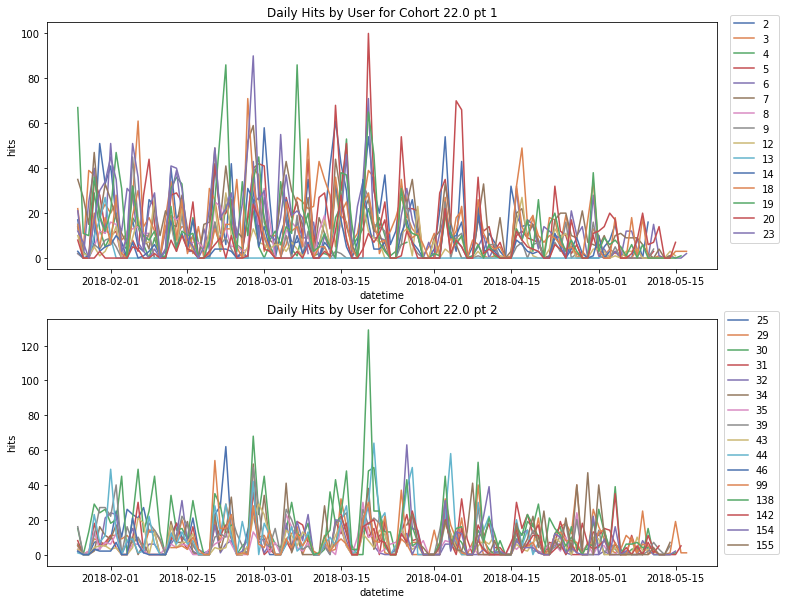

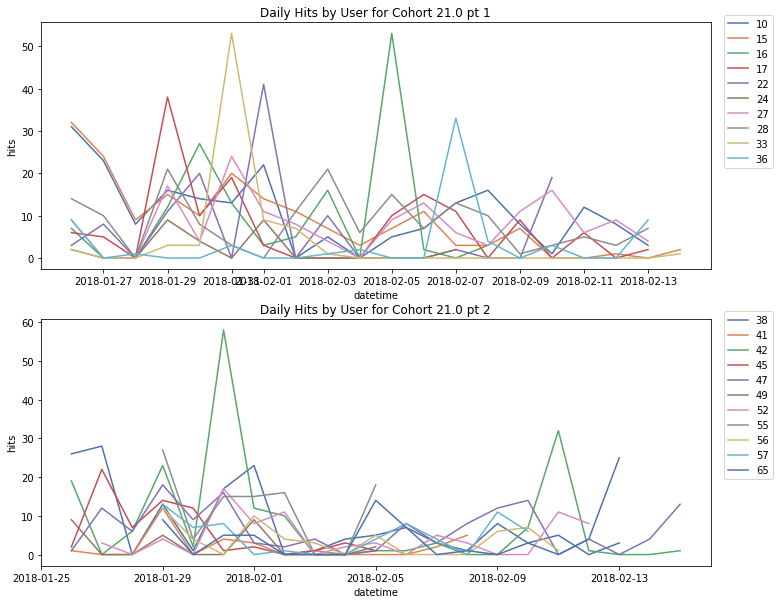

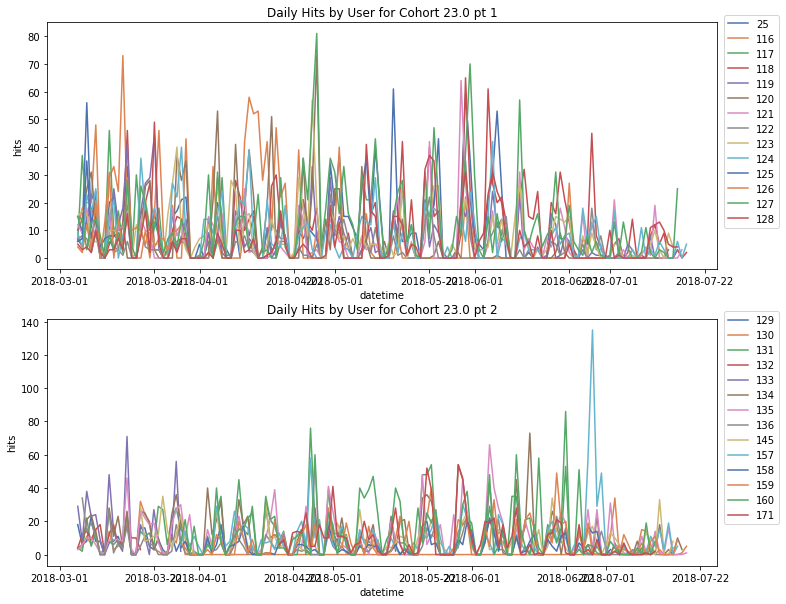

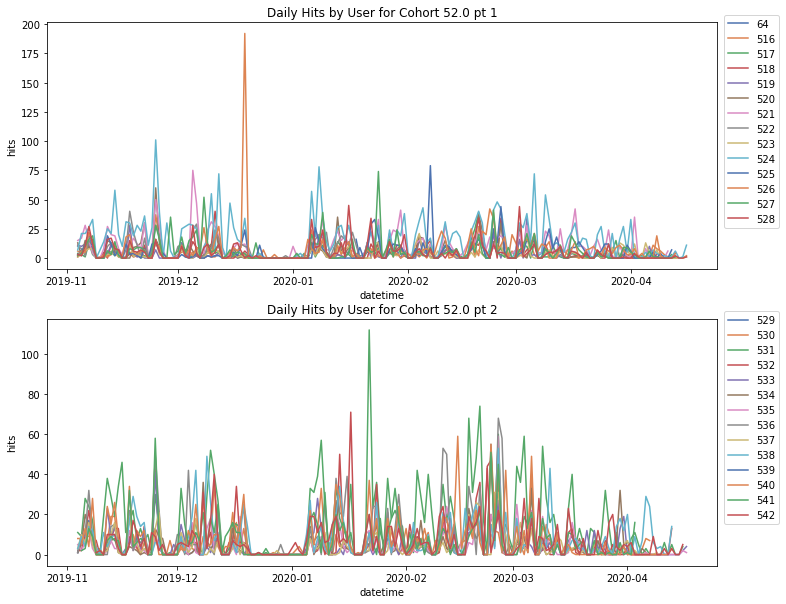

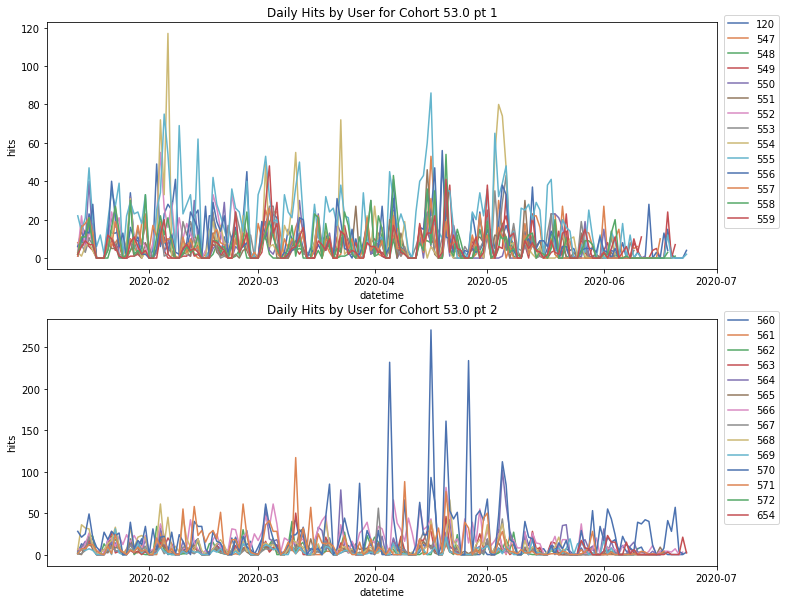

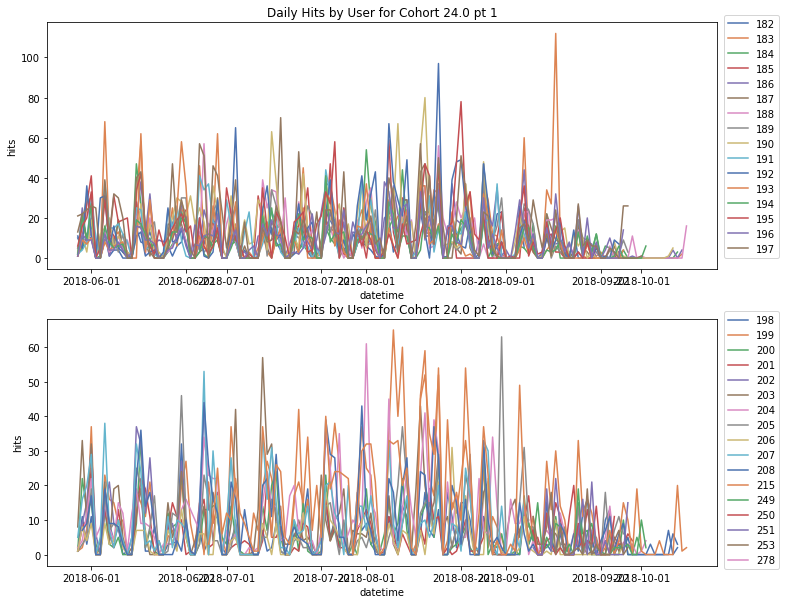

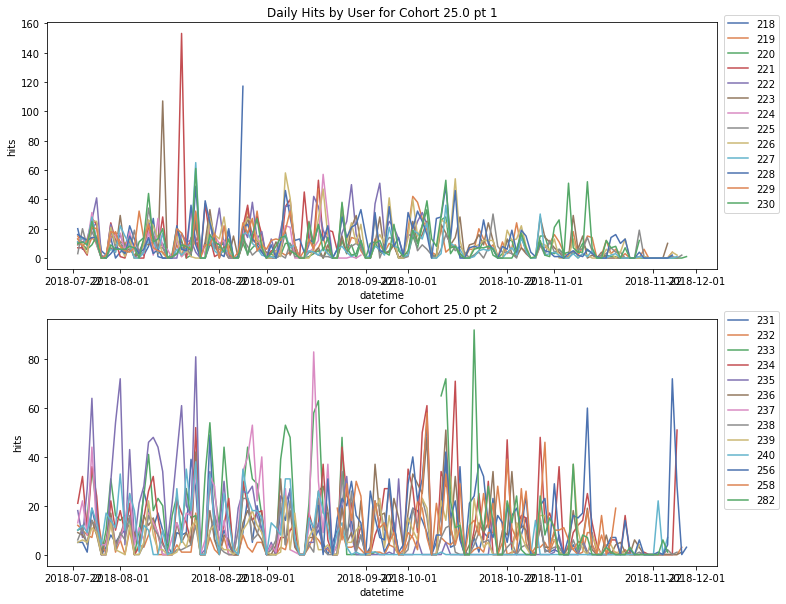

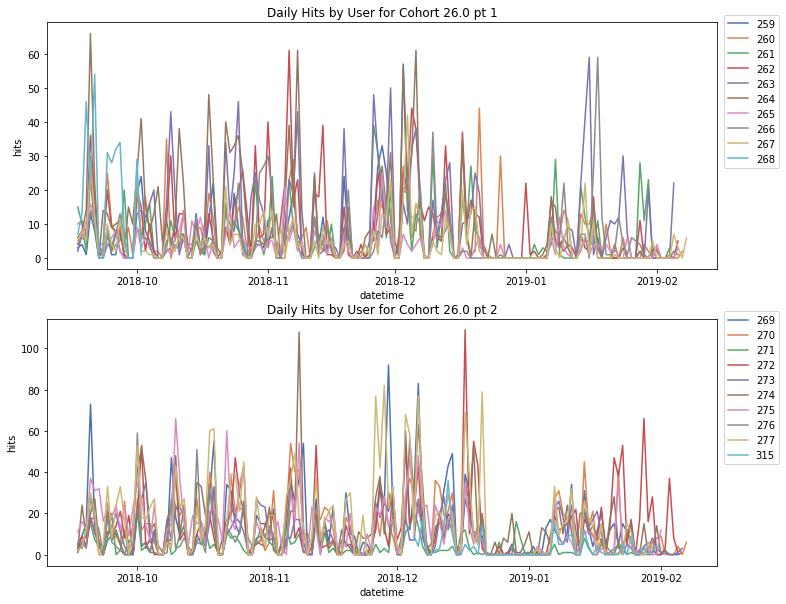

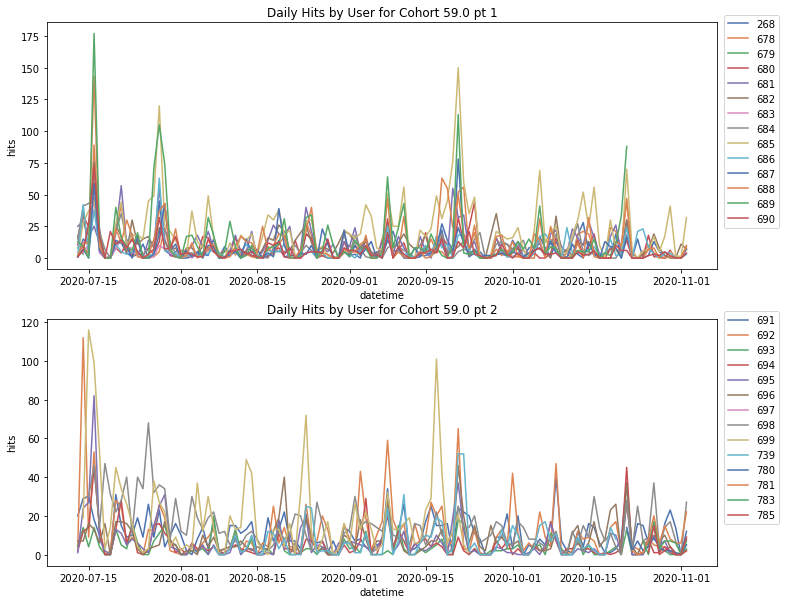

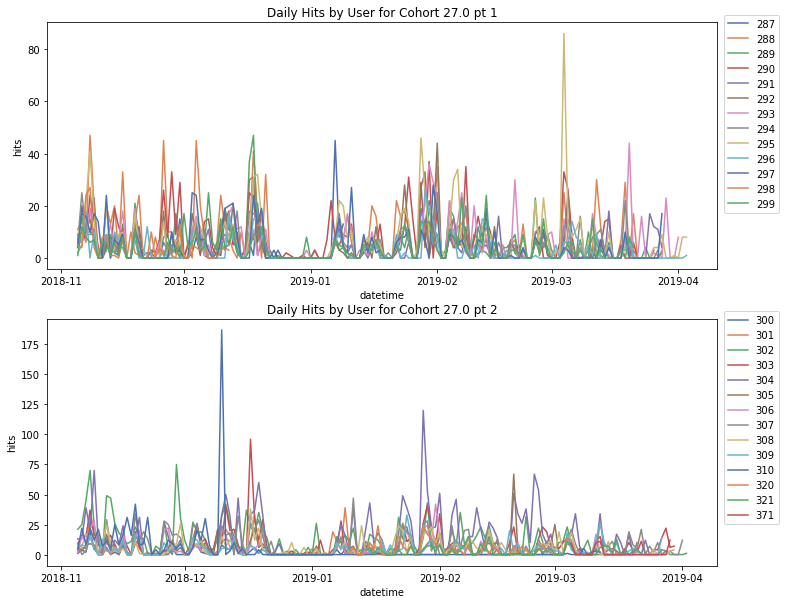

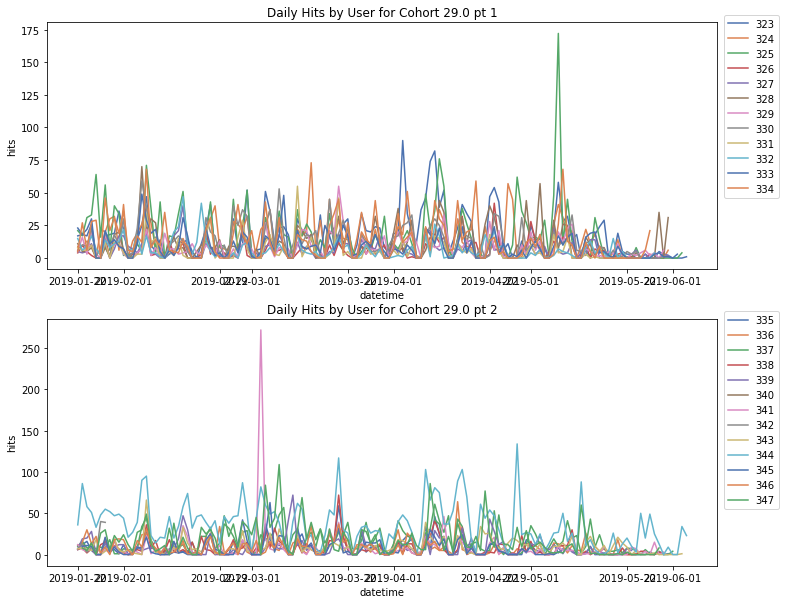

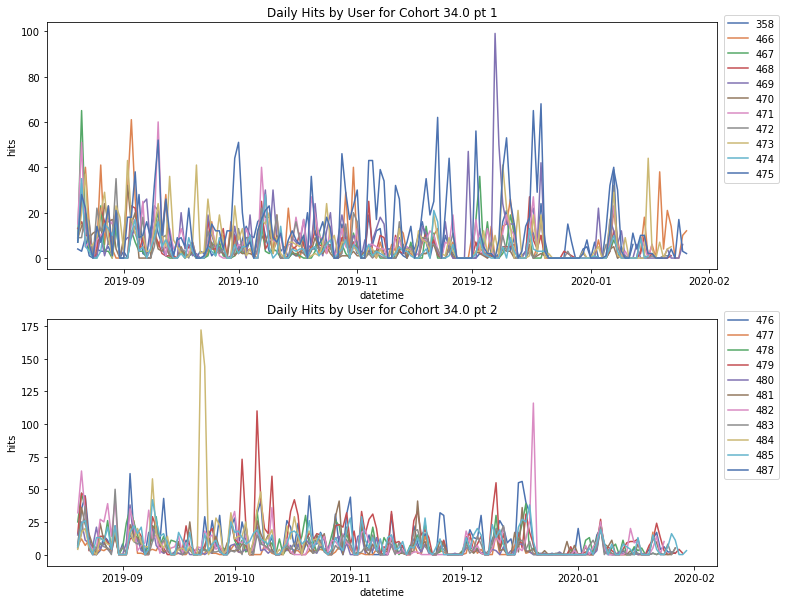

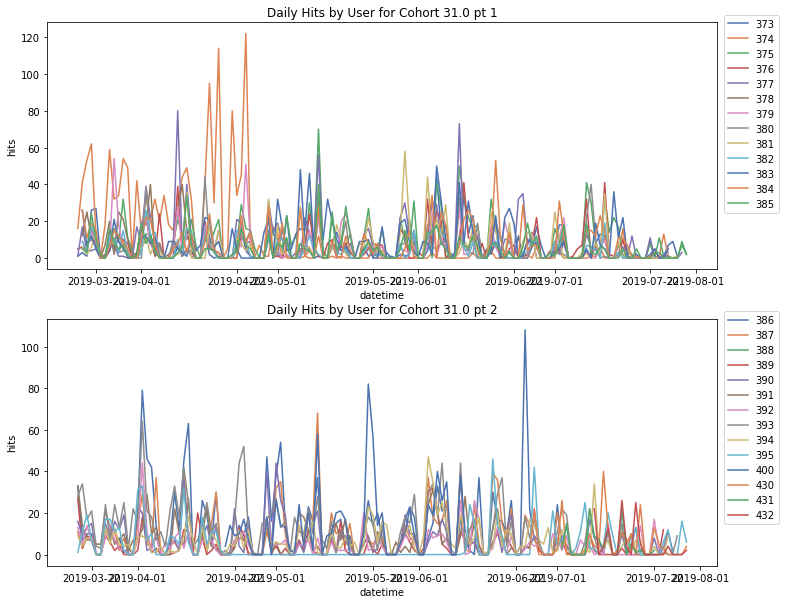

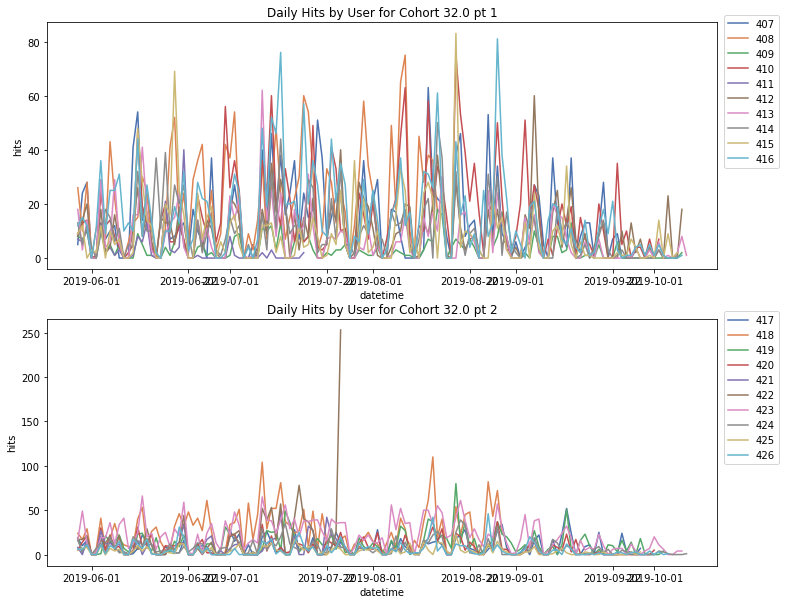

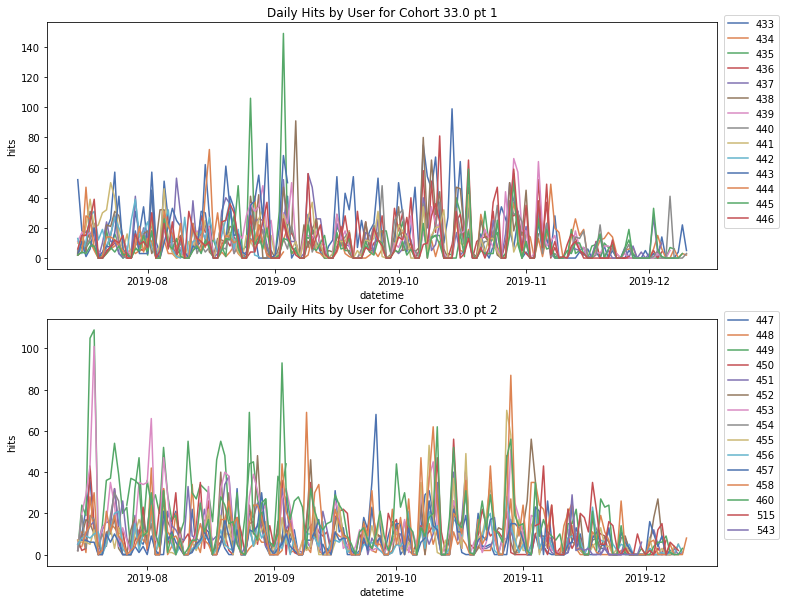

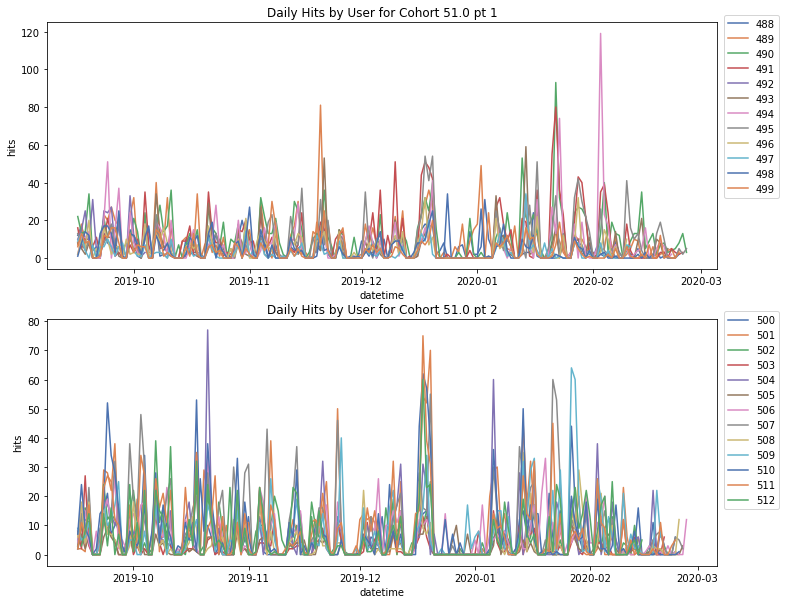

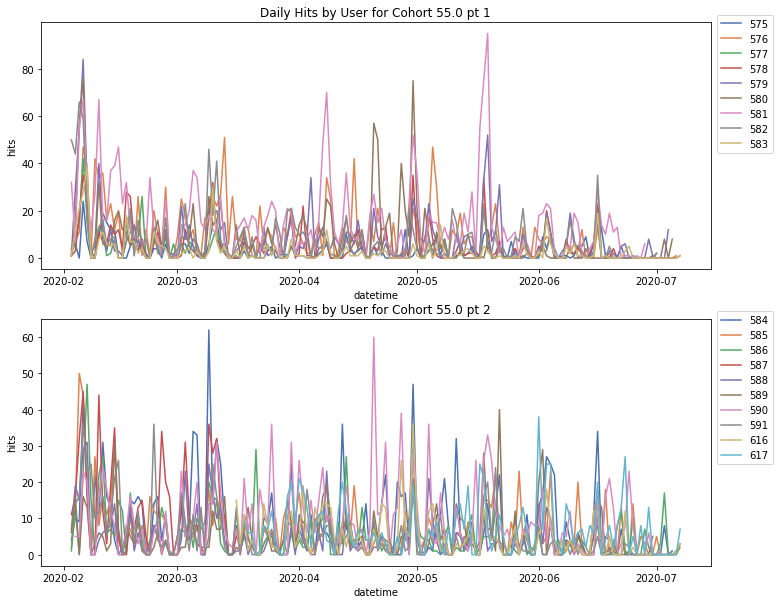

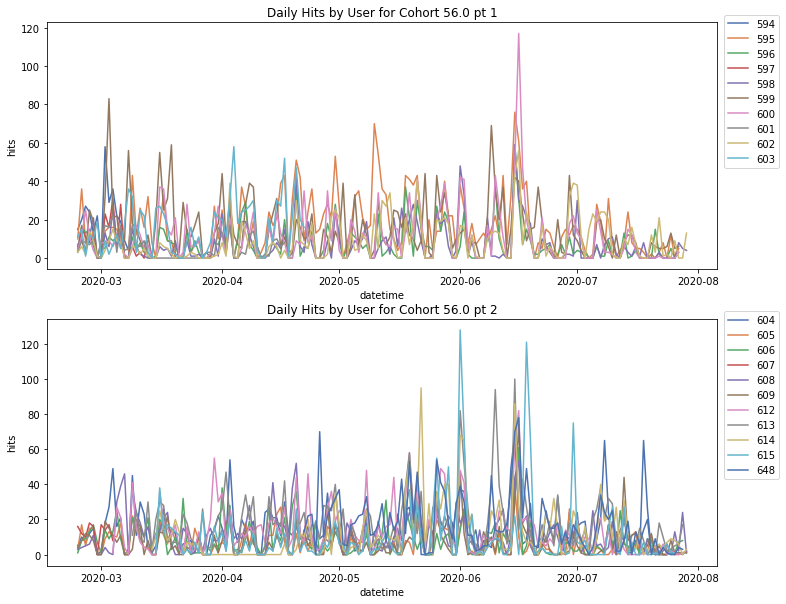

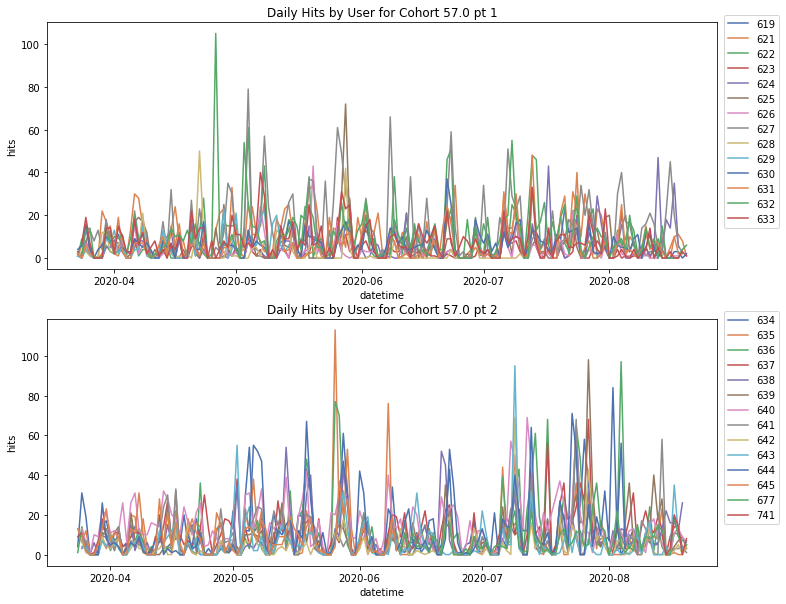

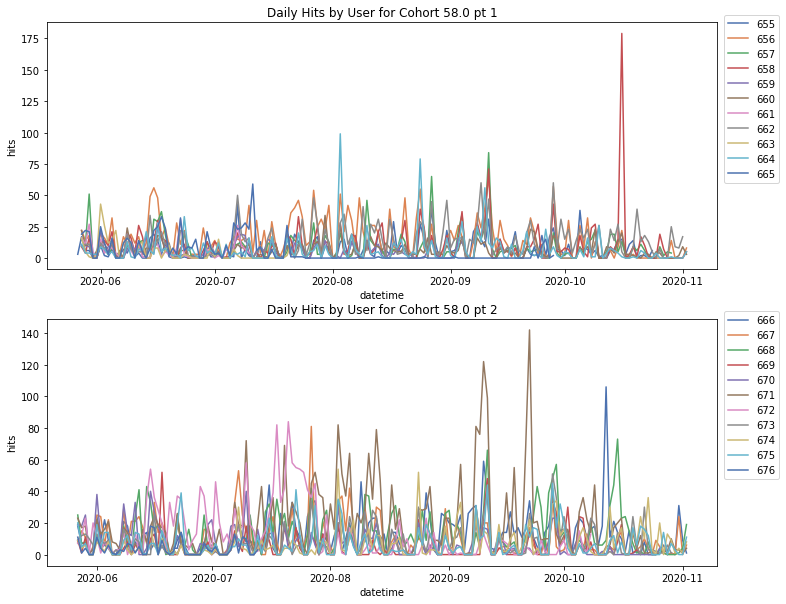

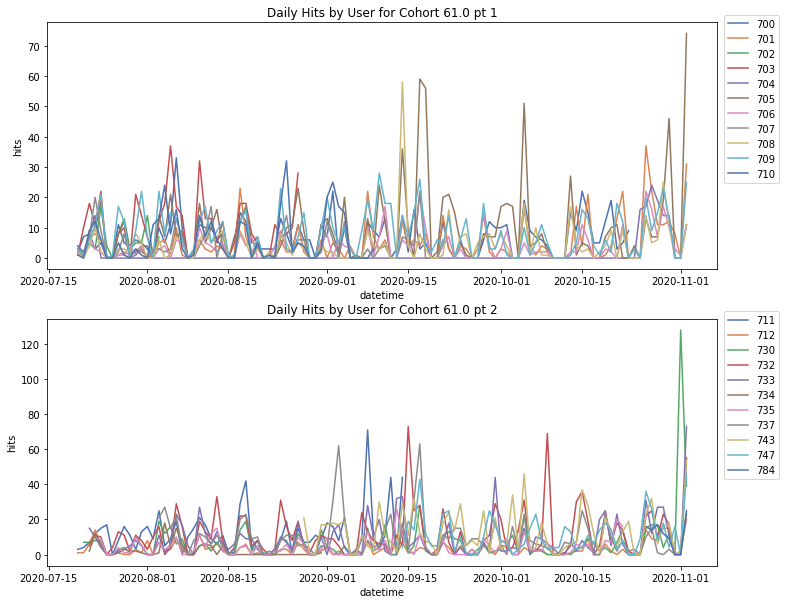

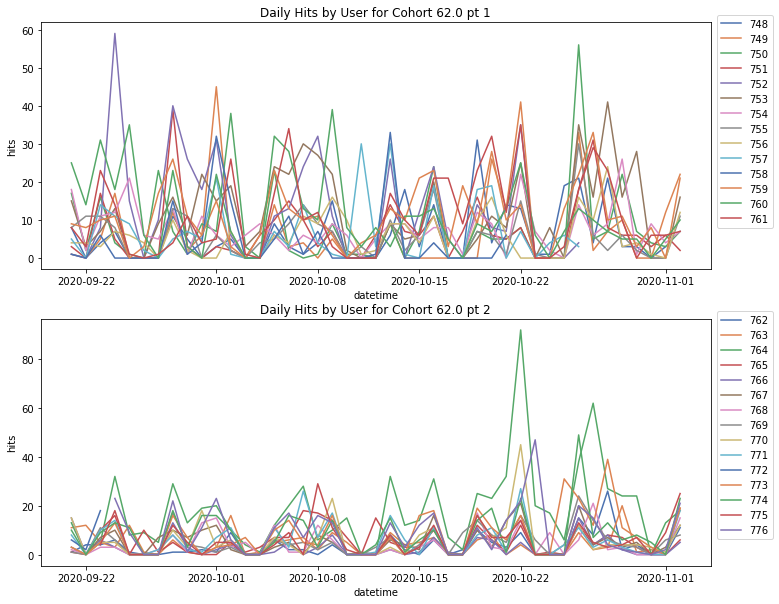

In [136]:
active_cohort_ids = list(daily_class['cohort_id'].unique())
for active_id in active_cohort_ids:
    plt.figure(figsize=(12, 10))
    plt.subplot(211)
    sns.lineplot(x=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] < statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].index, 
                 y=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] < statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].hits, 
                 hue=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] < statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].user_id, 
                 palette='deep')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(label=f'Daily Hits by User for Cohort {active_id} pt 1')
    plt.subplot(212)
    sns.lineplot(x=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] >= statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].index, 
                 y=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] >= statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].hits, 
                 hue=daily_class[(daily_class['cohort_id']==active_id) & (daily_class['user_id'] >= statistics.median(list(daily_class[daily_class['cohort_id']==active_id].user_id.unique())))].user_id, 
                 palette='deep')
    plt.title(label=f'Daily Hits by User for Cohort {active_id} pt 2')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

# After Graduation

In [81]:
# Create an empty data frame to store the data
active_grads = pd.DataFrame()
for cohort_id, end_date in zip(cohort.cohort_id, cohort.end_date):
    # Then for each cohort and end_date combo, only pull the rows where the class was still in session based on date
    active_grads = active_grads.append(data[(data['cohort_id'] == cohort_id) & (data['date'] > end_date)])

active_grads

date      time  \
30      2018-01-26  10:14:47   
31      2018-01-26  10:14:51   
33      2018-01-26  10:15:02   
134     2018-01-26  11:46:29   
136     2018-01-26  11:46:39   
...            ...       ...   
717802  2020-11-02  08:06:48   
717803  2020-11-02  08:06:51   
719397  2020-11-02  15:56:05   
719404  2020-11-02  15:58:51   
719407  2020-11-02  15:59:34   

                                              page_viewed  user_id  cohort_id  \
30                                                      /       11        1.0   
31                                           javascript-i       11        1.0   
33                                 javascript-i/functions       11        1.0   
134     appendix/further-reading/javascript/hoisting.html       11        1.0   
136                                              appendix       11        1.0   
...                                                   ...      ...        ...   
717802                                             spring      638       57.0   
717803                                       spring/setup      638       57.0   
719397                    spring/fundamentals/controllers      638       57.0   
719404                          spring/fundamentals/views      638       57.0   
719407                   spring/fundamentals/repositories      638       57.0   

                   ip            datetime  hour     day     month      name  \
30       97.105.19.61 2018-01-26 10:14:47    10  Friday   January    Arches   
31       97.105.19.61 2018-01-26 10:14:51    10  Friday   January    Arches   
33       97.105.19.61 2018-01-26 10:15:02    10  Friday   January    Arches   
134      97.105.19.61 2018-01-26 11:46:29    11  Friday   January    Arches   
136      97.105.19.61 2018-01-26 11:46:39    11  Friday   January    Arches   
...               ...                 ...   ...     ...       ...       ...   
717802  24.243.32.134 2020-11-02 08:06:48     8  Monday  November  Ganymede   
717803  24.243.32.134 2020-11-02 08:06:51     8  Monday  November  Ganymede   
719397  24.243.32.134 2020-11-02 15:56:05    15  Monday  November  Ganymede   
719404  24.243.32.134 2020-11-02 15:58:51    15  Monday  November  Ganymede   
719407  24.243.32.134 2020-11-02 15:59:34    15  Monday  November  Ganymede   

        start_date    end_date  program_id       classtype program    location  
30      2014-02-04  2014-04-22         1.0  Web-SanAntonio     Web  SanAntonio  
31      2014-02-04  2014-04-22         1.0  Web-SanAntonio     Web  SanAntonio  
33      2014-02-04  2014-04-22         1.0  Web-SanAntonio     Web  SanAntonio  
134     2014-02-04  2014-04-22         1.0  Web-SanAntonio     Web  SanAntonio  
136     2014-02-04  2014-04-22         1.0  Web-SanAntonio     Web  SanAntonio  
...            ...         ...         ...             ...     ...         ...  
717802  2020-03-23  2020-08-20         2.0      Web-Dallas     Web      Dallas  
717803  2020-03-23  2020-08-20         2.0      Web-Dallas     Web      Dallas  
719397  2020-03-23  2020-08-20         2.0      Web-Dallas     Web      Dallas  
719404  2020-03-23  2020-08-20         2.0      Web-Dallas     Web      Dallas  
719407  2020-03-23  2020-08-20         2.0      Web-Dallas     Web      Dallas  

[155027 rows x 17 columns]

web_class = web_avghits.drop(columns=['total_hits', 'total_avg']).transpose()
pages = web_class.columns
for page in pages:
    plt.figure(figsize=(20,10))
    plt.bar(x=web_class.index, height=web_class[page])
    plt.title(title=page)
    